In [1]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from one_phase import m1, m2, m3

from one_phase import one_phase
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

In [2]:
# model to be studied
def model(u):
    return [u**2+1, 2*max(u, 0), 2]

In [3]:
class Diffusion():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx+1, 1))
        for i in range(Nx+1):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

Несмотря на то, что в прошлом тесте не получилось превзойти метод Ньютона, попробуем улучшить результат засчет разбиения доменов

In [4]:
# we will take the same initial condition and grid parameters

Nx = 5000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
D = Diffusion(Nx, 0.9, 1, 0.4e-2, model=model)
x0 = 2*np.exp(-x)*np.sin(3*np.pi/2*x)**2
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]

In [5]:
prob = one_phase(D, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
solver_n.setSources([0.7], [-0.8])
nl_solver = newton(crit_abs=1e-6)
solver_n.setSolver(nl_solver)
solver_n.setInitial(x0)
X, mes, t, delta = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 48.38 +- 0.6248
mean newton iterations:  4.1


### Построение доменов через разбиение графа
Две формулировки функции на минимизацию:
$$
    vol(\partial S_i) = \sum_{v \in V_i} \sum_{u \in \Gamma(v), u \notin V_i} {w(v, u)}
$$
Первый способ:$$
\sum \frac{vol(\partial S_i)}{| V_i|} \rightarrow \min
$$Второй способ:$$
\sum \frac{vol(\partial S_i)}{vol(V_i)} \rightarrow \min
$$где $vol(V_i) = \sum_{u, v \in V_i} w(u, v)$

In [6]:
results = {}

In [7]:
Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver_eq = fxbd_1D(param, prob)
solver_eq.setBoundary(bd1, bd2)
solver_eq.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-6, newton_crit_rel = 1e-3)
solver_eq.setSolver(nl_solver)
solver_eq.setInitial(x0)
X, mes, t_as, delta_as = test(solver_eq, sample_size = 4)
results['eq'] = t_as
results['delta, eq'] = delta_as

test started
verdict : OK
time : 70.24 +- 1.5
mean aspen iterations:  3.9


--time comparision--
newton : 48.51718521118164
aspen : 68.69555187225342


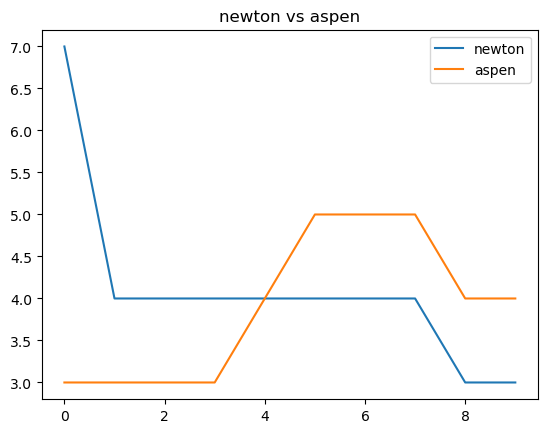

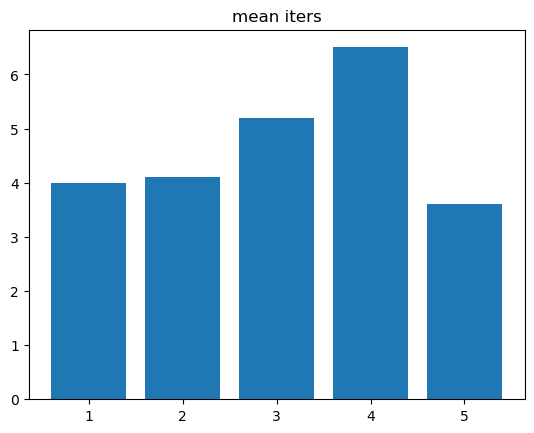

In [8]:
wp.compare([solver_n, solver_eq], ['newton', 'aspen'], save='comp, eq')
wp.bar_loc(solver_eq, Nd, save='bar, eq')

In [9]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 50)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m1(Jf, k, m)
    A1 = pt.adj_matrix(func1, Nx//50)
    #A1 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A1, Nd,
        inv = False, k =Nd)
    borders = borders * 50
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-6, newton_crit_rel = 1e-2)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd = True)
results['m1'] = t_as
results['delta, m1'] = delta_as

test started
[   0 1350 3050 3750 4250 5000]
[   0 1250 2950 3850 4300 5000]
[   0 1100 2850 3900 4400 5000]
[   0 1000 2700 3900 4400 5000]
[   0 1350 3050 3750 4250 5000]
[   0 1250 2950 3850 4300 5000]
[   0 1100 2850 3900 4400 5000]
[   0 1000 2700 3900 4400 5000]
[   0 1350 3050 3750 4250 5000]
[   0 1250 2950 3850 4300 5000]
[   0 1100 2850 3900 4400 5000]
[   0 1000 2700 3900 4400 5000]
[   0 1350 3050 3750 4250 5000]
[   0 1250 2950 3850 4300 5000]
[   0 1100 2850 3900 4400 5000]
[   0 1000 2700 3900 4400 5000]
verdict : OK
time : 68.26 +- 0.3486
mean aspen iterations:  3.9


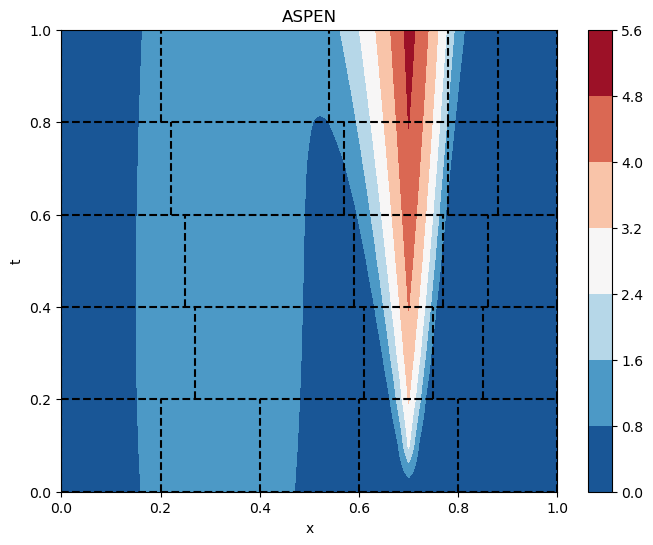

In [10]:
wp.show_res(solver, save='Diff0, m1')

--time comparision--
newton : 48.51718521118164
aspen : 67.28183150291443


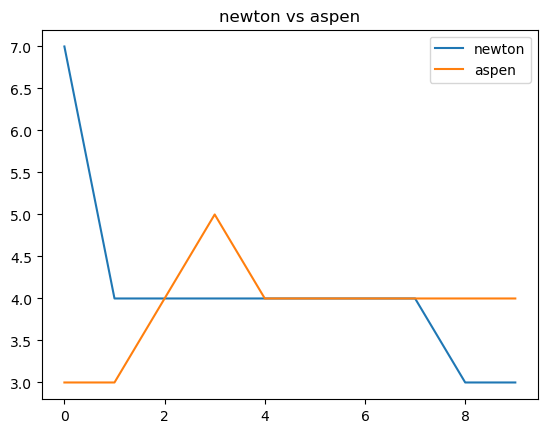

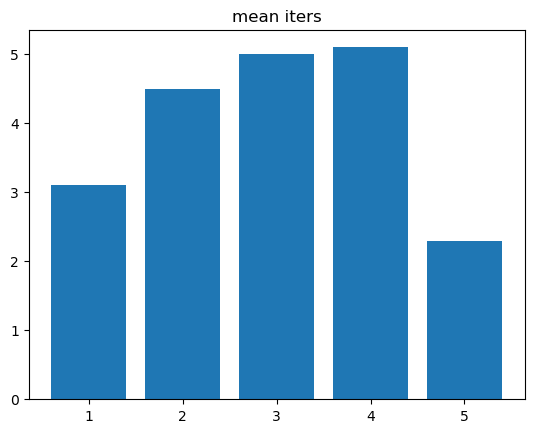

In [11]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m1')
wp.bar_loc(solver, Nd, save='bar, m1')

In [12]:
def border_changer(prob, X, nstep, Nd):
    func1 = lambda k, m: m2(X, k, m, x_step = 50)
    #func1 = lambda k, m: m2(X, k, m)
    A2 = pt.adj_matrix(func1, Nx//50)
    #A2 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A2, Nd,
        inv = True, k =Nd)
    borders = borders * 50
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-6, newton_crit_rel = 1e-2)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd = True)
results['m2'] = t_as
results['delta, m2'] = delta_as

test started
[   0  800 1950 3050 4200 5000]
[   0  800 1900 3050 4200 5000]
[   0  800 1900 3050 4200 5000]
[   0  800 1900 3050 4200 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
[   0  850 2100 3250 4450 5000]
verdict : OK
time : 66.77 +- 1.723
mean aspen iterations:  3.9


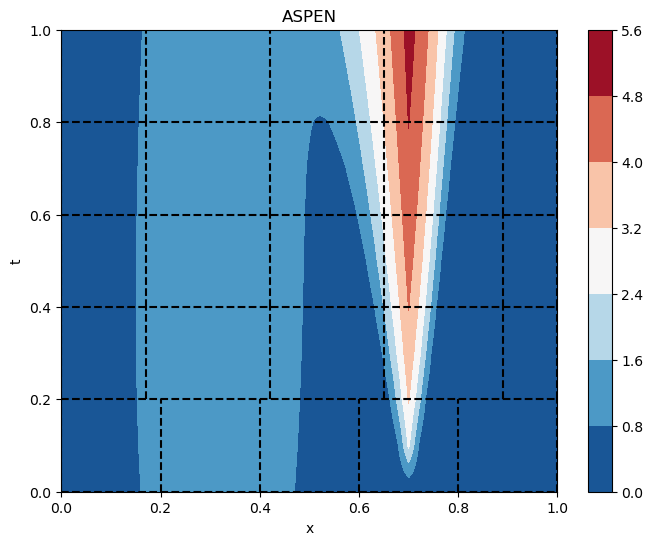

--time comparision--
newton : 48.51718521118164
aspen : 69.99839496612549


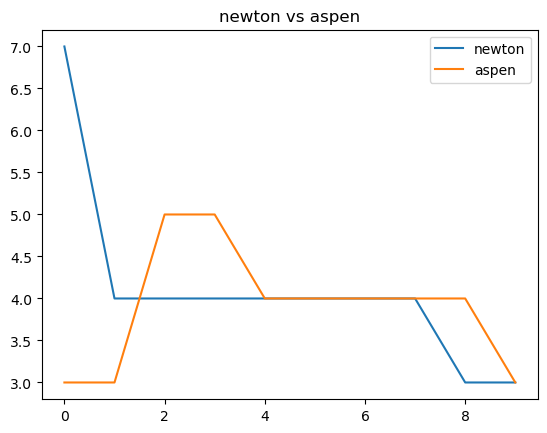

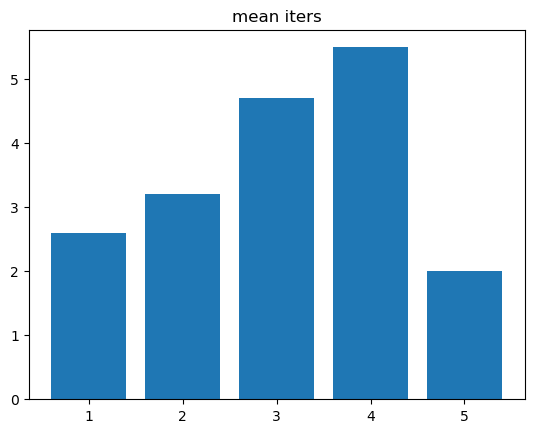

In [13]:
wp.show_res(solver, save='Diff0, m2')
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m2')
wp.bar_loc(solver, Nd, save='bar, m2')

In [16]:
def border_changer(prob, X, nstep, Nd):
    Jf = prob.precompute_Jf(X[:, nstep], Nx, step = 50)
    #Jf = prob.precompute_Jf(X[:, nstep], Nx)
    func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10, step = 50)
    #func1 = lambda k, m: m3(prob, X[:, nstep], Jf, k, m, 10)
    A3 = pt.adj_matrix(func1, Nx//50)
    #A3 = pt.adj_matrix(func1, Nx)
    borders = pt.domain_builder2(A3, Nd,
        inv = False, k =Nd)
    borders = borders * 50
    print(borders)
    return borders

Nd = 5
borders = pt.partion_equally(Nx, Nd)
param = {
    'Nx': Nx, 
    'Nt': Nt
}
prob = one_phase(D, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setSources([0.7], [-0.8])
nl_solver = aspen(Nd, borders, crit_abs = 1e-6, newton_crit_rel = 1e-2)
solver.setSolver(nl_solver, bd_ch = border_changer)
solver.setInitial(x0)
X, mes, t_as, delta_as = test(solver, sample_size = 4, dyn_bd=True)
results['m3'] = t_as
results['delta, m3'] = delta_as

test started
[   0  300 1050 1750 3400 5000]
[   0  450 1150 1950 3400 5000]
[   0  500 1200 2050 3400 5000]
[   0  650 1450 2700 3450 5000]
[   0  300 1050 1750 3400 5000]
[   0  450 1150 1950 3400 5000]
[   0  500 1200 2050 3400 5000]
[   0  650 1450 2700 3450 5000]
[   0  300 1050 1750 3400 5000]
[   0  450 1150 1950 3400 5000]
[   0  500 1200 2050 3400 5000]
[   0  650 1450 2700 3450 5000]
[   0  300 1050 1750 3400 5000]
[   0  450 1150 1950 3400 5000]
[   0  500 1200 2050 3400 5000]
[   0  650 1450 2700 3450 5000]
verdict : OK
time : 70.67 +- 0.8452
mean aspen iterations:  3.7


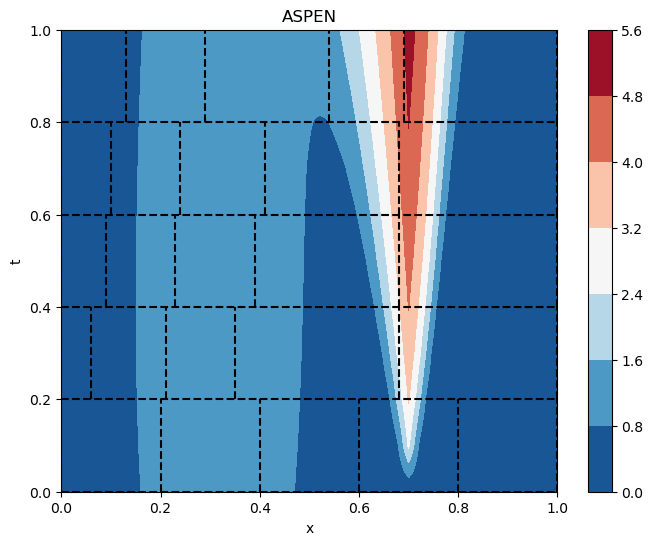

--time comparision--
newton : 48.51718521118164
aspen : 68.43116855621338


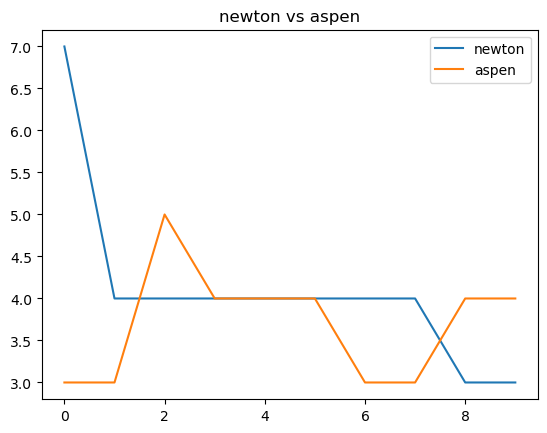

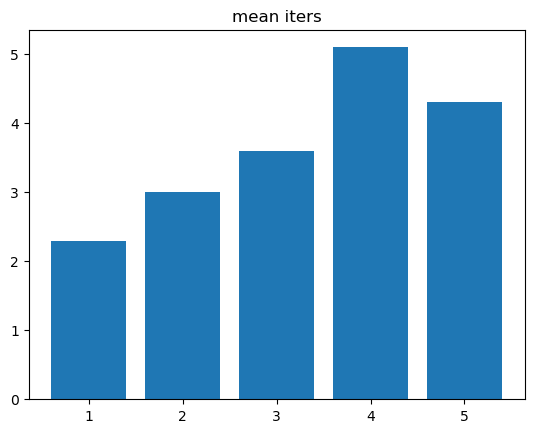

In [17]:
wp.show_res(solver, save='Diff0, m3')
wp.compare([solver_n, solver], ['newton', 'aspen'], save='comp, m3')
wp.bar_loc(solver, Nd, save='bar, m3')